# Clustering of e-commerce customers 

The goal is to test multiple unsupervised ML clustering algorithms and to create customer segmentation of brazilian e-commerce platform Olist Store, based on their transactions. 
The following algorithms are included: ...

Clustering allows for the creation of finite subsets of elements with similar characteristics, which allows to define their nature and to make rational business decisions based on it, for example by properly targeting marketing campaigns. One of the flagship examples of clustering is grouping customers according to the similarity of the products they purchase or the number of completed transactions, which is especially possible in electronic commerce, where the data is stored and processed continuously.

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. It was provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil, which allows them to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

The dataset is available publicly under CC BY-NC-SA 4.0 license. Further information can be found at https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce.


In [1]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Reading
dt_orders = pd.read_csv('data/olist_orders_dataset.csv', parse_dates=True)
dt_pay = pd.read_csv('data/olist_order_payments_dataset.csv', parse_dates=True)
dt_rev = pd.read_csv('data/olist_order_reviews_dataset.csv', parse_dates=True)
dt_items = pd.read_csv('data/olist_order_items_dataset.csv', parse_dates=True)
dt_prod = pd.read_csv('data/olist_products_dataset.csv', parse_dates=True)
dt_cust = pd.read_csv('data/olist_customers_dataset.csv', parse_dates=True)
dt_translation = pd.read_csv('data/product_category_name_translation.csv', parse_dates=True)
# dt_sellers = pd.read_csv('data/olist_sellers_dataset.csv', parse_dates=True)

# Joining chosen dfs & columns 
full_df = dt_orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',]]\
    .merge(dt_items[['order_id', 'product_id', 'price', 'freight_value']], on='order_id', how='inner')\
    .merge(dt_prod[['product_id', 'product_category_name']], on='product_id', how='left')\
    .merge(dt_translation, on='product_category_name', how='left')\
    .drop('product_category_name', axis=1)

In [5]:
full_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery


### Exploratory data analysis

In [12]:
# Shape:
for df in [dt_orders, full_df]:
    print(df.shape)

print("Max number of the same items bought at once: ", dt_items[['order_id', 'order_item_id']].groupby(['order_id']).count().max())

(99441, 8)
(112650, 8)
Max number of the same items bought at once:  order_item_id    21
dtype: int64


After merging the dataset grew by ~12k rows. After inspection, this is due to purchases with multiple products (for example 2 items at the same time by the same customer).
Because any purchase is relevant, these observations are left and each item is treated as a separate transaction. 

In [25]:
# Nulls:
full_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
product_id                          0
price                               0
freight_value                       0
product_category_name_english    1627
dtype: int64

In [31]:
full_df[full_df.isnull().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,a1804276d9941ac0733cfd409f5206eb,49.90,16.05,NaN
122,bfe42c22ecbf90bc9f35cf591270b6a7,803ac05904124294f8767894d6da532b,delivered,2018-01-27 22:04:34,71225f49be70df4297892f6a5fa62171,27.30,15.10,NaN
212,58ac1947c1a9067b9f416cba6d844a3f,ee8e1d37f563ecc11cc4dcb4dfd794c2,delivered,2017-09-13 09:18:50,9820e04e332fc450d6fd975befc1bc28,110.00,14.16,NaN
264,e22b71f6e4a481445ec4527cb4c405f7,1faf89c8f142db3fca6cf314c51a37b6,delivered,2017-04-22 13:48:18,3bc5164bc7f4be77002d6651da65c98c,22.50,11.74,NaN
303,a094215e786240fcfefb83d18036a1cd,86acfb656743da0c113d176832c9d535,delivered,2018-02-08 18:56:45,5a848e4ab52fd5445cdc07aab1c40e48,122.99,9.06,NaN
...,...,...,...,...,...,...,...,...
112228,1a10e938a1c7d8e5eecc3380f71ca76b,8a81607347c25d881d995d94de6ad824,delivered,2018-07-25 08:58:35,8d39a63db6a98e40571f486e0c711cf7,127.20,18.99,NaN
112397,e33865519137f5737444109ae8438633,64b086bdcc54458af3ea3bd838db54a5,delivered,2018-05-28 00:44:06,e9cbc0910ab050cbd92fbeb051c270ea,33.85,8.29,NaN
112404,f0dd9af88d8ef5a8e4670fbbedaf19c4,30ddb50bd22ee927ebe308ea3da60735,delivered,2017-09-02 20:38:29,0c877471e35049402bca235e06cb8063,84.90,15.35,NaN
112410,272874573723eec18f23c0471927d778,48e080c8001e92ebea2b64e474f91a60,delivered,2017-12-20 23:10:33,5a848e4ab52fd5445cdc07aab1c40e48,122.99,9.06,NaN


In [28]:
full_df.product_category_name_english.nunique()

71

The data has some missing values for product types, which is a categorical variable with 71 different values. The provided information in the dataset does not allow to 'find' and perform imputation in place of the missing ones, but regardless, many clustering algorithms cannot accept categorical variables due to how they work (like the basic k-means). For this reason, right now this column is not a problem and dropping the nulls is not required (would cause losing 1% of data).

However, this categorical variable variable is used later on and the missing values are there addressed.  

<ipython-input-70-7e41a85c9455>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


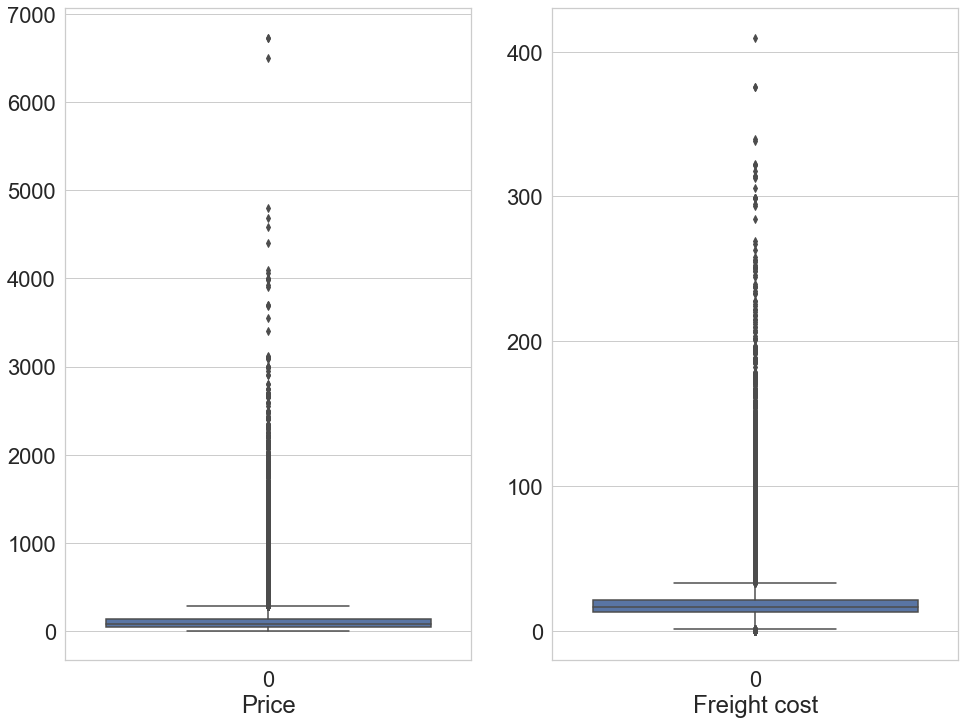

In [70]:
# outliers
plt.rcParams["figure.figsize"] = (16,12)
fig, ax = plt.subplots(1,2)
sns.set(style="whitegrid", font_scale=2)
sns.boxplot(data=full_df['price'], ax=ax[0]).set(xlabel='Price')
sns.boxplot(data=full_df['freight_value'], ax=ax[1]).set(xlabel='Freight cost')
fig.show()

In [73]:
full_df[full_df.price>5000]

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
3925,f5136e38d1a14a4dbd87dff67da82701,3fd6777bbce08a352fddd04e4a7cc8f6,delivered,2017-05-24 18:14:34,1bdf5e6731585cf01aa8169c7028d6ad,6499.0,227.66,art
25071,0812eb902a67711a1cb742b3cdaa65ae,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12 20:37:36,489ae2aa008f021502940f251d4cce7f,6735.0,194.31,housewares
32077,fefacc66af859508bf1a7934eab1e97f,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,computers


In [74]:
full_df[full_df.freight_value>350]

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
57086,a77e1550db865202c56b19ddc6dc4d53,4eed76c1aafeceac4250e202ca9b1a5a,delivered,2018-04-16 14:57:21,ec31d2a17b299511e7c8627be9337b9b,979.00,409.68,baby
84927,076d1555fb53a89b0ef4d529e527a0f6,f08306b95370e8d5f0d97b71229284b6,delivered,2018-07-30 10:04:21,a3cd9517ebf5a50dca25acce54f3b171,2338.08,375.28,housewares
111396,3fde74c28a3d5d618c00f26d51baafa0,f2c743697f9b2ff2902df23a16582d80,delivered,2018-08-13 14:07:50,a3cd9517ebf5a50dca25acce54f3b171,2338.08,375.28,housewares


In [ ]:
full_df_iqr = 

There are multiple observations that fall outside of the interquartile ranges for the Price and Freight value. However, there are no reasons to believe these are faulty records. In fact, there are only a few values cleary outstanding from the rest of the population. As their effect on clustering is unknown, datasets with (full_df) and without (full_df_iqr) outliers will be tested.  